# Slicing Experiment 1 with PySlice Library

This notebook demonstrates how to use the new PySlice library instead of the original NetworkSlicer class.

In [1]:
import torch
import torch.nn as nn
from PytorchNetwork import TestNetwork
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import math, os, shutil, time

# Import the new PySlice library
import pyslice

In [2]:
np.random.seed(123)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

def sinsin(x,y):
    return np.sin(x)+np.sin(y)

def createData(f,size=1024,maxrange=5):
    l = []
    samplesPerDim = int(np.sqrt(size))
    step = maxrange/(samplesPerDim-1)
    for x in range(0,samplesPerDim):
        for y in range(0,samplesPerDim):
            l.append({'x':[x*step,y*step],'y':f(x*step,y*step)})
    return l

def getRandomVector(model,length):
    w = list(np.array(model.getWeights())*0)
    b = list(np.array(model.getBiases())*0)
    wb = w+b
    for i in range(len(wb)):
        wb[i] = np.random.normal()
    wb = wb/np.linalg.norm(wb)*length
    return {'weights':list(wb[:len(w)]),'biases':list(wb[len(w):])}

## Initialize Model and PySlice Components

Instead of using the NetworkSlicer class, we'll use the PySlice library components.

In [3]:
#Generate training and test data
trainingData = createData(sinsin,1024)
testData = createData(sinsin,1024)

#Initialize model
neurons = 1
layersShape = [2,neurons,neurons,1]
model = TestNetwork(layersShape=layersShape)
model.device = torch.device("cpu")
model.setActivationFunction("sigmoid")
model.setLossFunction("mse")

# Initialize PySlice model wrapper
model_wrapper = pyslice.ModelWrapper(
    model=model, 
    training_data=trainingData, 
    test_data=testData
)

# Initialize the axis-parallel slicer
slicer = pyslice.AxisParallelSlicer(model_wrapper)

# Computational settings
model_wrapper.min_value = -10
model_wrapper.max_value = 10
numOfSamplingPoints = 200
sampleSize = 101

#Create random weights
initVec = getRandomVector(model,1.0)

#Create trained weights using PySlice optimizer
from pyslice.utils.optimization import optimize_parameters
trajectory = optimize_parameters(
    model_wrapper=model_wrapper,
    epochs=10000,
    loss_threshold=0.01,
    max_seconds=10,
    batch_size=0,
    optimizer_type="adam"
)
tVec = trajectory[-1]  # Get the final optimized parameters

w = tVec['weights']
b = tVec['biases']
print("loss", model_wrapper.compute_loss({'weights': w, 'biases': b}))
dim = len(w)+len(b)

2.6.0
loss 0.3078380823135376
loss 0.3078380823135376


In [4]:
# Generate random sampling vectors using PySlice
samplingVectors = slicer.get_random_points(
    center_point=tVec,
    quantity=numOfSamplingPoints,
    sampling_method="uniform",
    radius=1
)

# Compute slices for the optimized parameters
trained_params = {'weights': tVec['weights'], 'biases': tVec['biases']}
center_slice_data = slicer.compute_slices(trained_params, sample_size=sampleSize)

# Compute slices for random points (using a smaller subset for speed)
random_slices = []
for params in samplingVectors[:numOfSamplingPoints]:
    random_slices.append(
        slicer.compute_slices(
            {'weights': params['weights'], 'biases': params['biases']},
            sample_size=sampleSize
        )
    )

## Prepare Data for Visualization

We'll prepare the data in the format expected by the original plotting code, for consistency.

In [5]:
# Convert the slice data to the format expected by the original plotting code
charts = [[] for i in range(dim)]

# Process center point slices
center_slices = np.array(center_slice_data['slices'])
for d in range(len(center_slices)):
    s = [center_slices[d][:, 0], center_slices[d][:, 1]]
    charts[d].append(s)

# Process random point slices
for random_slice in random_slices:
    rand_slices = np.array(random_slice['slices'])
    for d in range(len(rand_slices)):
        s = [rand_slices[d][:, 0], rand_slices[d][:, 1]]
        charts[d].append(s)

## Visualize Slices

Now we can use either the original visualization code or the PySlice visualizer.

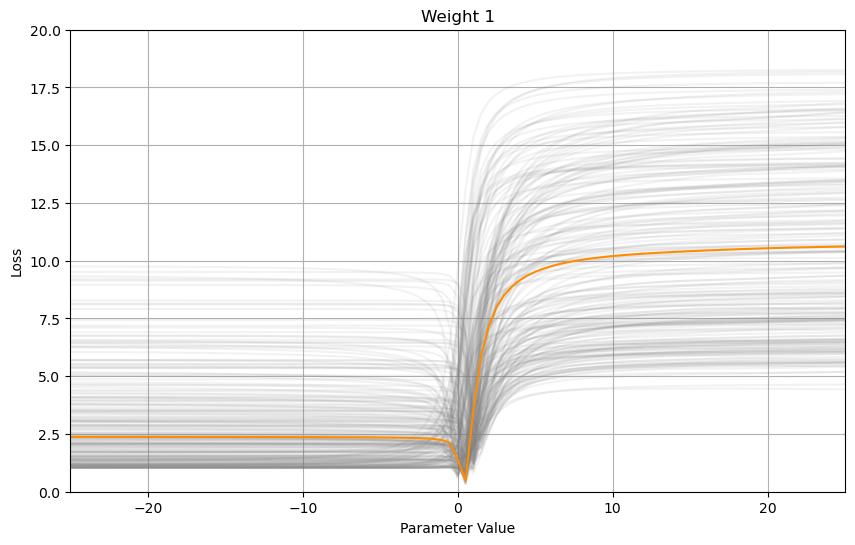

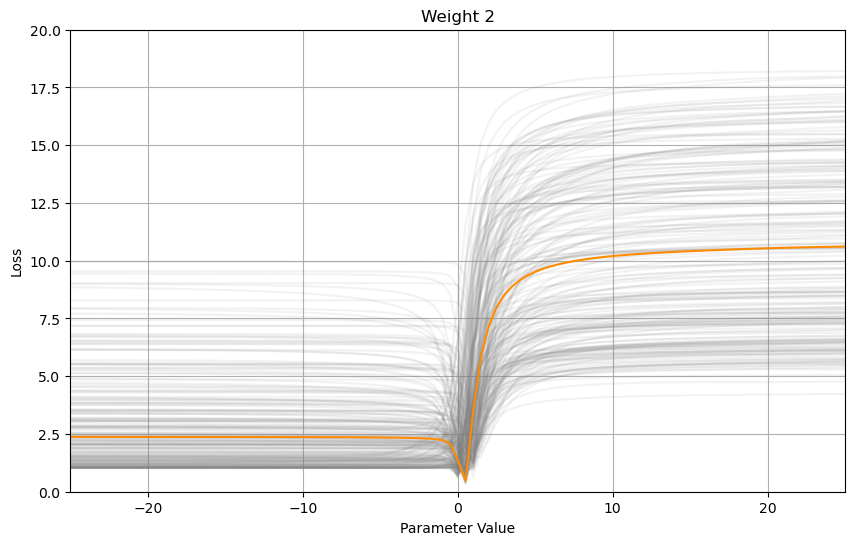

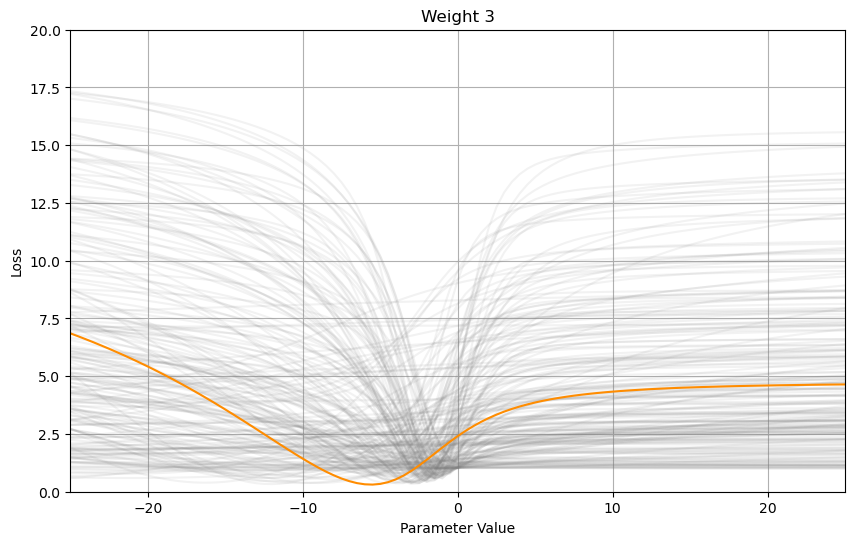

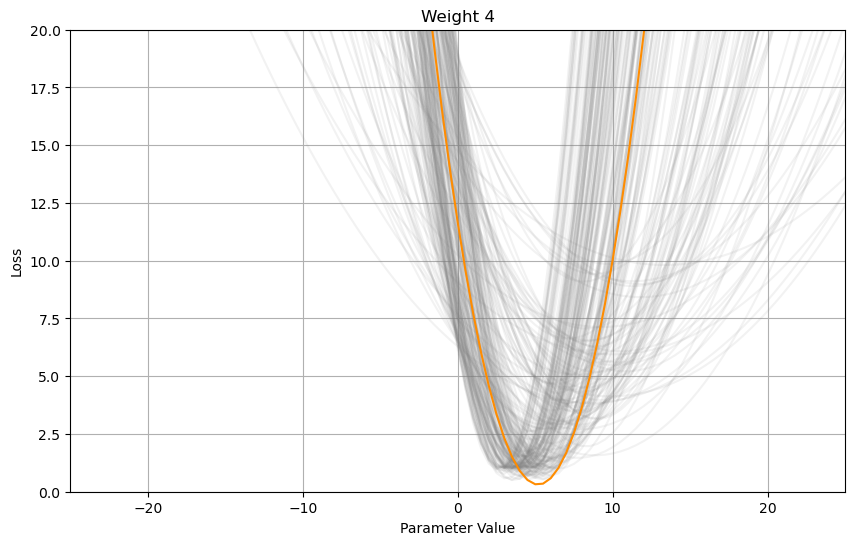

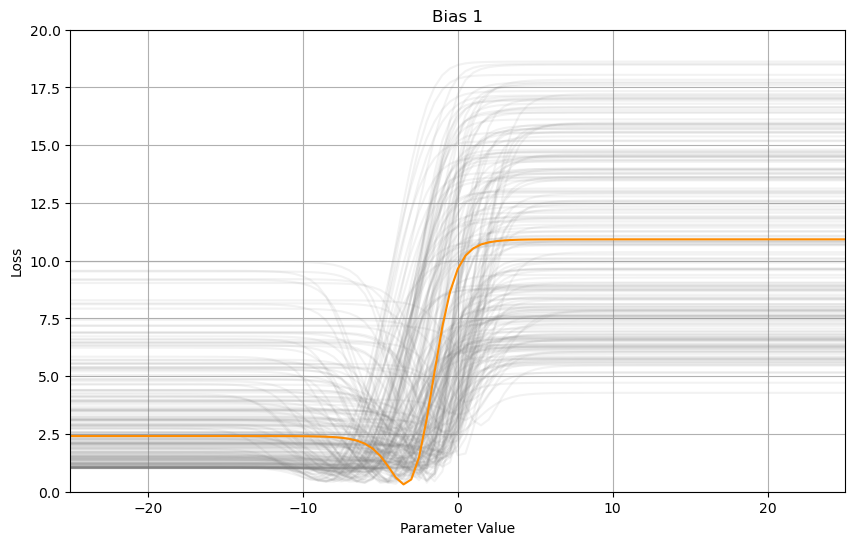

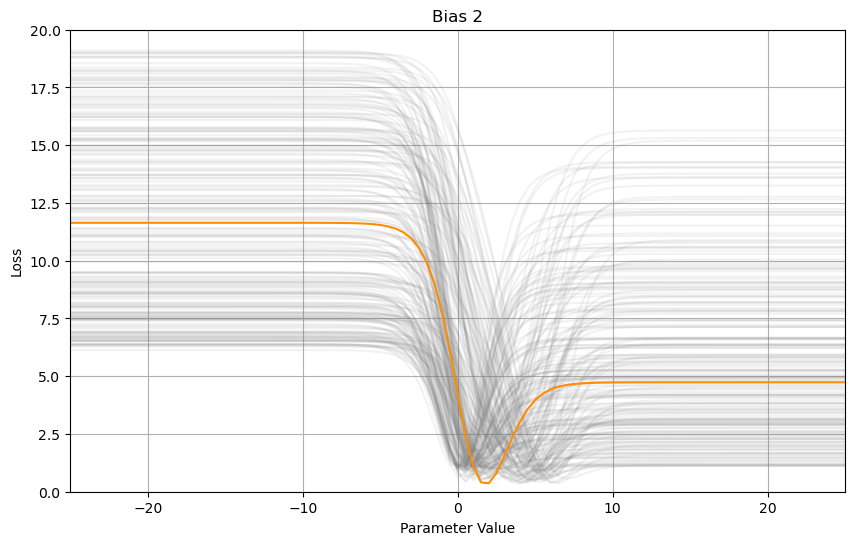

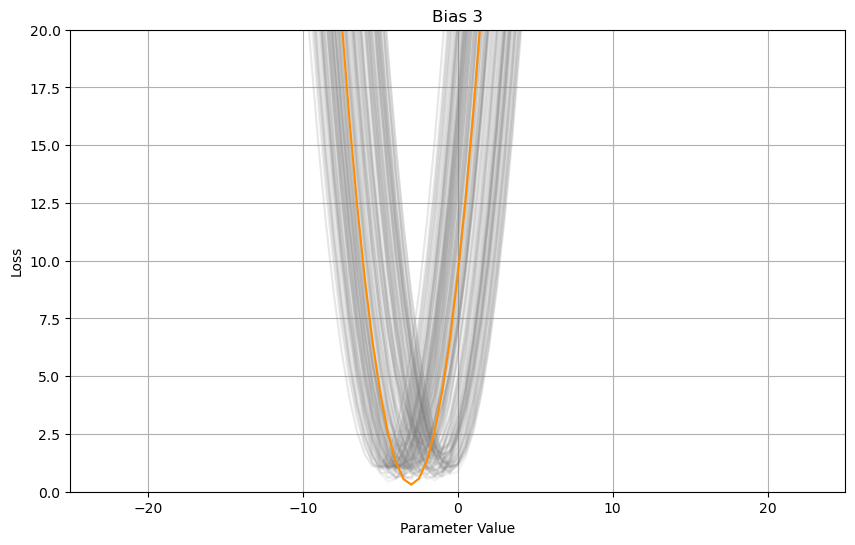

In [6]:
# Option 1: Use PySlice's visualizer
visualizer = pyslice.SliceVisualizer()
visualizer.plot_multiple_slices(
    charts_data=charts,
    weights_length=len(w),
    settings={
        'slice_opacity': 0.1,
        'min_y': 0,
        'max_y': 20,
        'min_x': -10,
        'max_x': 10,
    },
    show=True
)

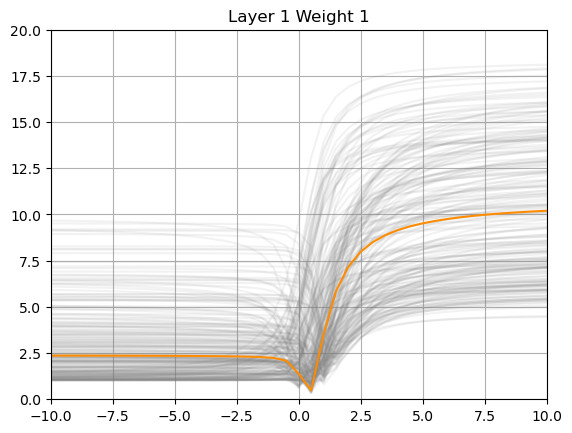

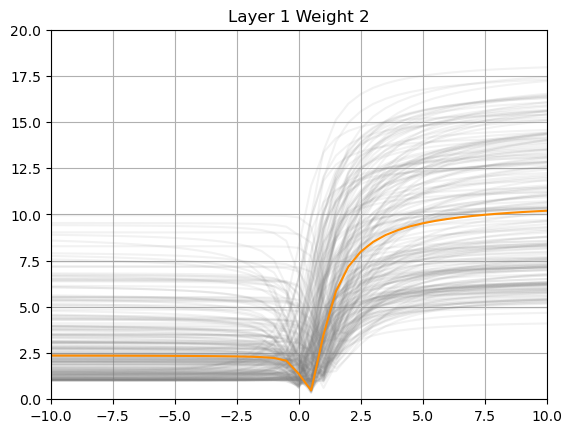

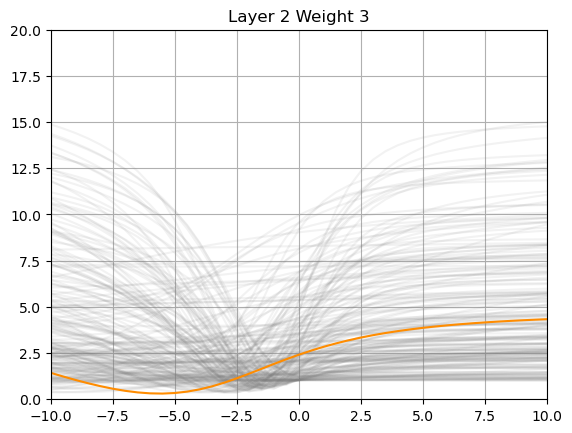

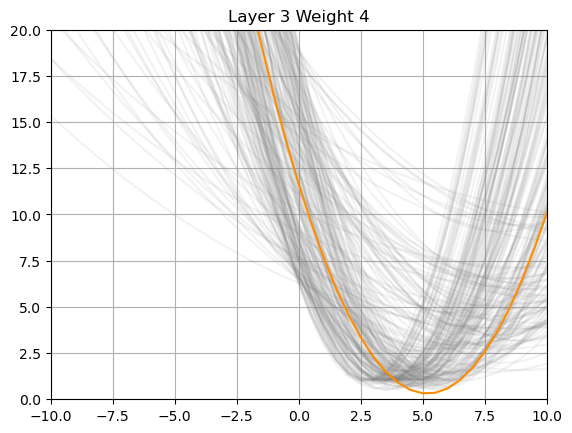

In [7]:
# Option 2: Use the original visualization code
#Visual settings
sliceOpacity = 0.1
minY = 0
maxY = 20
minX = -10
maxX = 10

#Plot weights
for l in range(len(model.weightsPerLayer)-1):
    for d in range(model.weightsPerLayer[l],model.weightsPerLayer[l+1]):
        e = charts[d]
        #Random vectors
        for i in range(1,len(e)):
            plt.plot(e[i][0],e[i][1],color="grey",alpha=sliceOpacity)
        #Center vector
        plt.plot(e[0][0],e[0][1],color="darkorange",alpha=1.0)
        plt.ylim(minY,maxY)
        plt.xlim(minX,maxX)
        plt.grid()
        plt.title("Layer "+str(l+1)+" Weight "+str(d+1))
        plt.show()

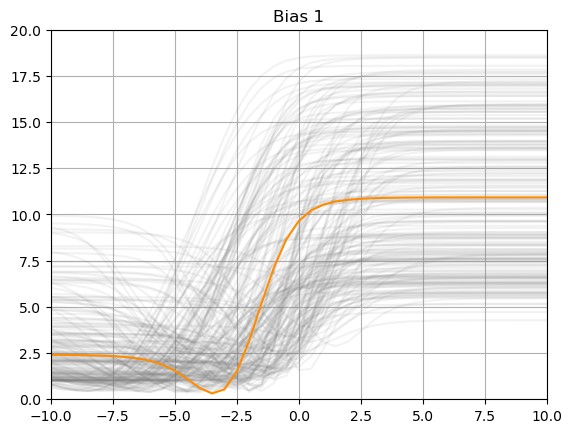

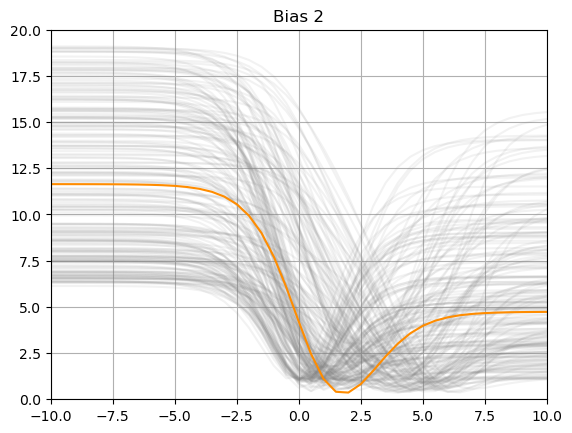

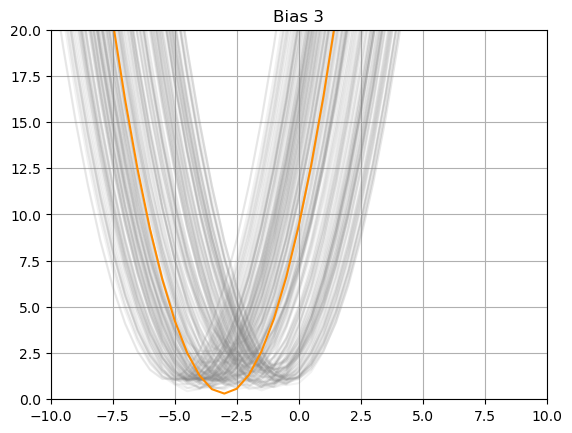

In [8]:
#Plot biases
for d in range(len(w),dim):
    e = charts[d]
    #Random vectors
    for i in range(1,len(e)):
        plt.plot(e[i][0],e[i][1],color="grey",alpha=sliceOpacity)
    #Center vector
    plt.plot(e[0][0],e[0][1],color="darkorange",alpha=1.0)
    plt.ylim(minY,maxY)
    plt.xlim(model_wrapper.min_value,model_wrapper.max_value)
    plt.grid()
    plt.title("Bias "+str(d-len(w)+1))
    plt.show()

## Performance Measurement

We can measure the performance of our slicing operations using PySlice's performance metrics.

In [9]:
from pyslice.utils.metrics import measure_sampling_performance

performance = measure_sampling_performance(
    slicer=slicer,
    center_point=trained_params,
    sample_size=sampleSize,
    num_runs=3
)

print(f"Performance: {performance['samples_per_second']:.2f} samples/second")
print(f"Average time: {performance['avg_time_seconds']:.4f} seconds")
print(f"Total samples: {performance['total_samples']}")

Performance: 718.75 samples/second
Average time: 0.9836 seconds
Total samples: 707


In [10]:
print("Init:")
print("L2",np.linalg.norm(initVec['weights']+initVec['biases']))
print("Loss",model_wrapper.compute_loss(initVec))
print(initVec)

print("\nTrained:")
print("L2",np.linalg.norm(tVec['weights']+tVec['biases']))
print("Loss",model_wrapper.compute_loss(tVec))
print(tVec)

Init:
L2 1.0
Loss 2.3697099685668945
{'weights': [np.float64(-0.2957662032677851), np.float64(0.27171403899782476), np.float64(0.07709388047905515), np.float64(-0.4103707717739669)], 'biases': [np.float64(-0.15763225466769534), np.float64(0.4499128092280729), np.float64(-0.6611177910654427)]}

Trained:
L2 9.077294222081193
Loss 0.3078380823135376
{'weights': [0.38967427611351013, 0.38967427611351013, -5.595070838928223, 5.186716079711914], 'biases': [-3.4125943183898926, 1.779667615890503, -3.0122616291046143], 'loss': 0.3078380823135376}


In [11]:
def save(fileName,content):
    f = open(fileName,"w")
    f.write(str(content))
    f.close()

import json
save("targetVector_pyslice.txt",json.dumps(tVec))
save("samplingVectors_pyslice.txt",json.dumps(samplingVectors))